# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2022
## Домашнее задание 3. Сравнение оценок и эффективные оценки

Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде, 
* собственно кодом, 
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача в этом задании оценивается в **15 баллов**.

## Пожалуйста, не переименовывайте этот ноутбук

In [ ]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid", font_scale=1.4)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample', 'var', 'median', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Задача 1

Сгенерируйте выборку из трех распределений: нормального, Лапласа и Коши размера `N=500`.

Далее для всех графиков в этом задании используйте обозначенные цвета для каждого из распределений (даже если графики будут на разных осях). То есть если график касается нормального распределения то рисуйте его синим цветом.

In [ ]:
color_for_normal=sns.color_palette("colorblind")[0]
color_for_laplace=sns.color_palette("colorblind")[1]
color_for_cauchy=sns.color_palette("colorblind")[2]

N=500

norm_distr = sps.norm()
laplacian_distr = sps.laplace()
cauchy_distr = sps.cauchy()
np.random.seed(2020)

sample_norm = norm_distr.rvs(size=N)
sample_laplacian = laplacian_distr.rvs(size=N)
sample_cauchy = cauchy_distr.rvs(size=N)


Постройте график плотности распределения для всех трех распределений на одних осях.

Text(0.5, 1.0, 'Плотности распределений')

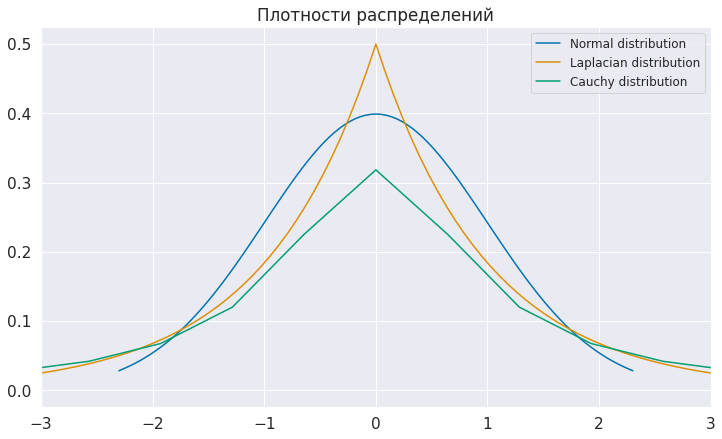

In [ ]:
colors = [color_for_normal, color_for_laplace, color_for_cauchy]
names = ['Normal distribution', 'Laplacian distribution', 'Cauchy distribution']


plt.figure(figsize=(12, 7))
for distr, color, label in zip([norm_distr, laplacian_distr, cauchy_distr], 
                                colors,
                                names):
  bins = np.linspace(distr.ppf(0.01), distr.ppf(0.99), 100)
  bin_centers = 0.5*(bins[1:] + bins[:-1])
  pdf = distr.pdf(bin_centers)
  plt.plot(bin_centers, pdf, color=color, label=label)
plt.legend(fontsize=12)
plt.xlim(-3,3)
plt.title('Плотности распределений')

Подумайте для каких распределений сложнее найти значение математического ожидания по выборке? Почему?

**Ответ:** для распределения Коши не существет математического ожидания. 

Часто, в реальной жизни, мы сталкиваемся с данными в которых есть выбросы возникшие, например, из-за опечаток. Пусть в выборке содержится 99 точек на интервале $[0;1]$ и один элемент равный 300. Тогда среднее значение нашей выборки будет не меньше трех. Ясно, что так дело не пойдет, что же делать?

Можно использовать медиану или **усеченное среднее**.

**Усеченное среднее порядка $\alpha$** это среднее составленное из выборки от которой отрезаны $\alpha$ и $1 - \alpha$ квантили. Как ее получить?


1.   Отсортировать выборку
2.   Отрезать первые и последние ($\alpha \cdot \text{размер выборки}$) элементов выборки
3.   Посчитать среднее полученной выборки

Напишите функцию для подсчета этой статистики.

In [ ]:
import math

def truncated_mean(sample, alpha=0.3):
    sample = np.array(sample)
    num = round(alpha * sample.shape[0])

    sample.sort()
    sort_cut = (sample[num:])[:num]
    return sort_cut.mean()

**Теорема**
Пусть распределение симметрично относительно нуля и имеет одну моду в нуле, тогда асимптотическая дисперсия усеченного среднего порядка $\alpha$ может быть выражена по формуле:
$$
\sigma^2(\alpha) = 2\cdot\frac{\int_0^{u_{1 - \alpha}} x^2 dF(x) + \alpha\cdot(u_{1 - \alpha})^2}{(1 - 2\alpha)^2},
$$

где $u_\alpha$ – квантиль порядка $\alpha$.

Напишите функцию, которая это делает.

*Подсказка.* Для численного интегрирования используйте функцию `quad` из модуля `scipy.integrate`

Немного преобразуем формулу:
$$
\sigma^2(\alpha) = 2\cdot\frac{\int_0^{u_{1 - \alpha}} x^2 p(x) dx + \alpha\cdot(u_{1 - \alpha})^2}{(1 - 2\alpha)^2},
$$  где $p(x)$ -- плотность распределния, соответсвующего функции распределения $F(X).$

In [ ]:
from scipy.integrate import quad

def asymp_var(distr, alpha):
    quantile = distr.ppf(1 - alpha)
    I = quad(lambda x: (x ** 2) * distr.pdf(x), 0 , quantile)
    return 2 * ((I[0] + alpha * (quantile ** 2)) / ((1 - 2 * alpha) ** 2))

Постройте графики для асимптотической дисперсии в зависимости от $\alpha$ для всех трех распределений на разных осях (используйте `plt.subplots(1, 3, figsize=(21,7))`). **Не забудьте про цвета**. Для заголовка графика используйте `ax[i].set_title`, для заголовка всей картинки используйте `fig.suptitle`.

Text(0.5, 0.98, 'Графики асимптотической дисперсии в зависисмотси от порядка квантили для разных распределений')

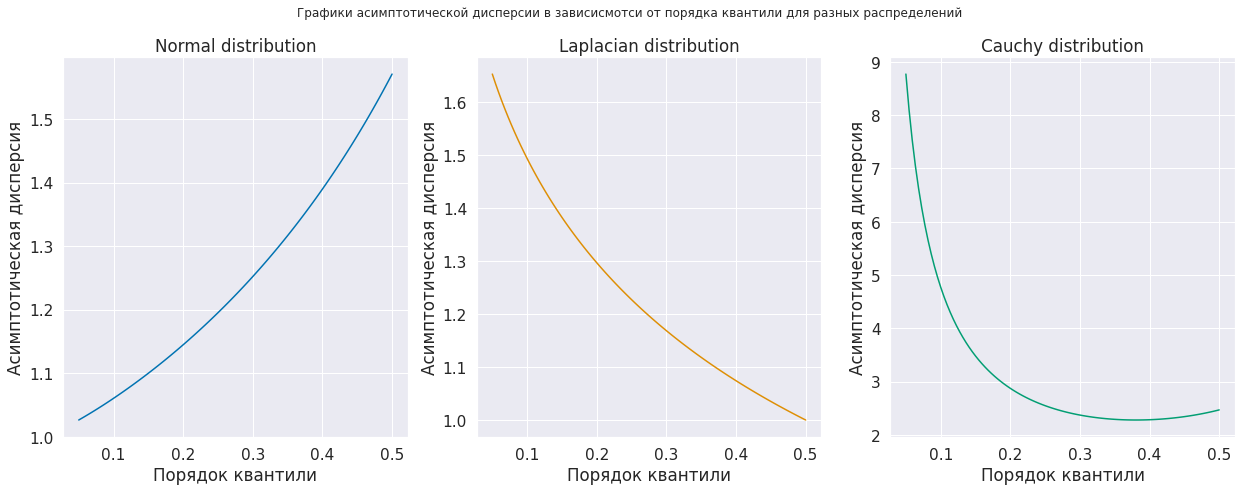

In [ ]:
alpha_grid = np.linspace(0.05, 0.49999, 100)

sample = [norm_distr, laplacian_distr, cauchy_distr]
fig, ax = plt.subplots(1, 3, figsize=(21,7))
for i, color, name in zip(range(3), colors, names):
    y = []
    for alpha in alpha_grid:
        y.append(asymp_var(sample[i], alpha))

    ax[i].plot(alpha_grid, y, color=color)
    ax[i].set_title(name)
    ax[i].set_xlabel('Порядок квантили')
    ax[i].set_ylabel('Асимптотическая дисперсия')
fig.suptitle('Графики асимптотической дисперсии в зависисмотси от порядка квантили для разных распределений')

Как можно интепретировать такой график? Напишите развернутый вывод.

*Подсказка.* Подумайте, какой известной оценке соответствует усеченное среднее порядка 0.5? А порядка 0?

**Ответ:** усечённое среднее порядка 0.5 соответсвует медиане выборки (median), порядка 0 $-$ среднему (mean). Поэтому можно сделать вывод, что для  нормального распределения асимптотическая дисперсия для среднего меньше, чем для медианы. Для распределения Коши и Лапласа наоброт: меньшему значению асомптотической дисперсии соответсвует медиана, среднее $-$ большему.

Для каждого распределение на отдельном графике постройте значение трех оценок: среднего, медианы и усеченного среднего порядка $0.35$. Для усеченного среднего проведите линию пунктиром (`fmt="--"`), для медианы точечками (`fmt=":"`). **Не забудьте про цвета**. То есть цвета на одном графике одинаковые, разные оценки отличает только формат линии.

**Ниже посчитайте все оценки необходимые для всех распределений**

**Нормальное распределение**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Значание оценки')

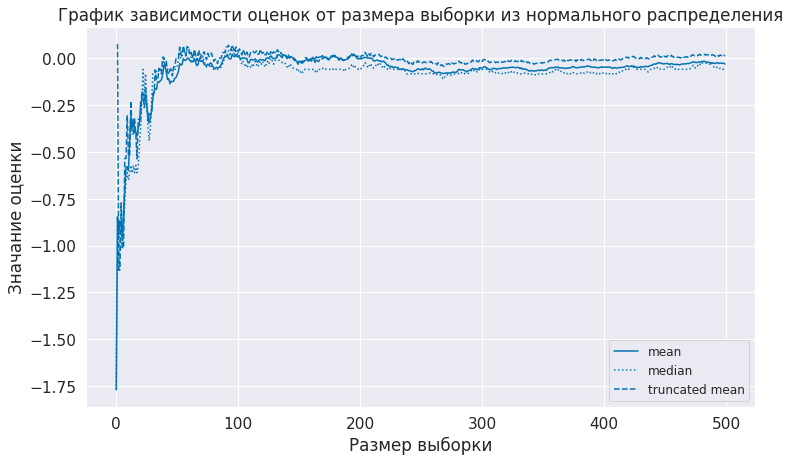

In [ ]:
norm_mean = []
norm_median = []
norm_cut_mean = []

for i in range(1, N + 1):
  norm_mean.append(sample_norm[:i].mean())
  norm_median.append(np.median(sample_norm[:i]))
  norm_cut_mean.append(truncated_mean(sample_norm[:i], 0.35))


plt.figure(figsize=(12,7))
plt.plot(norm_mean, color=color_for_normal, label='mean')
plt.plot(norm_median, ':', color=color_for_normal, label='median')
plt.plot(norm_cut_mean, '--', color=color_for_normal, label='truncated mean')
plt.legend(fontsize=12)
plt.title('График зависимости оценок от размера выборки из нормального распределения')
plt.xlabel('Размер выборки')
plt.ylabel('Значание оценки')

**Распределение Лапласа**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


Text(0, 0.5, 'Значание оценки')

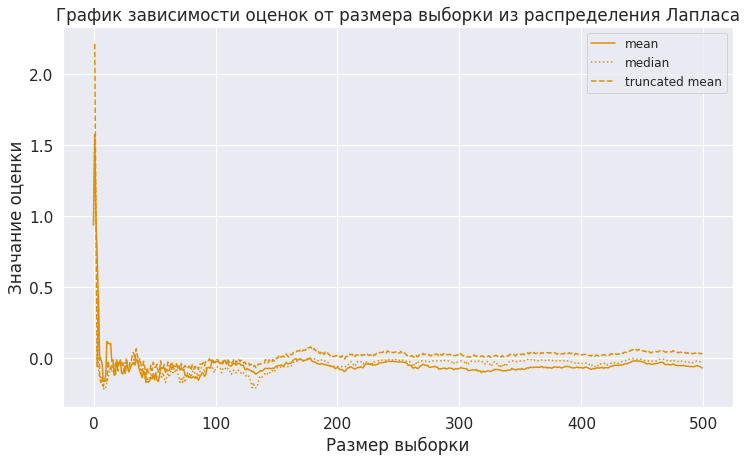

In [ ]:
laplacian_mean = []
laplacian_median = []
laplacian_cut_mean = []

for i in range(1, N + 1):
  laplacian_mean.append(sample_laplacian[:i].mean())
  laplacian_median.append(np.median(sample_laplacian[:i]))
  laplacian_cut_mean.append(truncated_mean(sample_laplacian[:i], 0.35))


plt.figure(figsize=(12,7))
plt.plot(laplacian_mean, color=color_for_laplace, label='mean')
plt.plot(laplacian_median, ':', color=color_for_laplace, label='median')
plt.plot(laplacian_cut_mean, '--', color=color_for_laplace, label='truncated mean')
plt.legend(fontsize=12)
plt.title('График зависимости оценок от размера выборки из распределения Лапласа')
plt.xlabel('Размер выборки')
plt.ylabel('Значание оценки')

**Распределение Коши**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


Text(0, 0.5, 'Значание оценки')

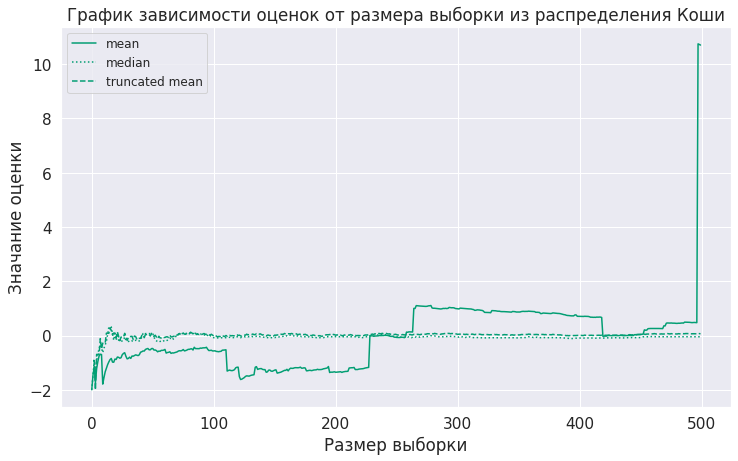

In [ ]:
cauchy_mean = []
cauchy_median = []
cauchy_cut_mean = []

for i in range(1, N + 1):
  cauchy_mean.append(sample_cauchy[:i].mean())
  cauchy_median.append(np.median(sample_cauchy[:i]))
  cauchy_cut_mean.append(truncated_mean(sample_cauchy[:i], 0.35))


plt.figure(figsize=(12,7))
plt.plot(cauchy_mean, color=color_for_cauchy, label='mean')
plt.plot(cauchy_median, ':', color=color_for_cauchy, label='median')
plt.plot(cauchy_cut_mean, '--', color=color_for_cauchy, label='truncated mean')
plt.legend(fontsize=12)
plt.title('График зависимости оценок от размера выборки из распределения Коши')
plt.xlabel('Размер выборки')
plt.ylabel('Значание оценки')

Как эти три графика соотносятся с графиками асимптотической дисперсии усеченного среднего для всех этих распределений? Сделайте вывод.

**Вывод:** данные графики подтверждают вывод, сделанный ранее. \
На графике для нормального распрделения среднее ближе к усечённому среднему, чем медиана, при этом все три оценки хорошо сходятся.\
На графике для распределния Лапласа медиана ближе к усечённому среднему, чем среднее.\
Для распредления Коши среднее значение не сходится, в то время как усечённое среднее и медиана даже при небольшом размере выборки хорошо сходятся к 0.

# Задача 2

## Wine dataset

Давайте загрузим и проанализируем датасет, состоящий из различных показателей для красного вина и оценок сомелье. 

In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1LsNeROfnVQb2ksdtwZvxrZREdy_Z-jta

Downloading...
From: https://drive.google.com/uc?id=1LsNeROfnVQb2ksdtwZvxrZREdy_Z-jta
To: /content/winequality-red.csv
100% 101k/101k [00:00<00:00, 37.9MB/s]


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("winequality-red.csv")

In [ ]:
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Поделите вина на три категории по содержанию алкоголя. Добавьте колонку `"category"` со значениями `"low alcohol"`, `"medium alcohol"`, `"high alcohol"` для относительного объемного содержания алкоголя `x<=10`, `10 < x <= 12`, `x > 12` соответственно.

In [ ]:
conditions = [
    (data['alcohol'] <= 10),
    (data['alcohol'] > 10) & (data['alcohol'] <= 12),
    (data['alcohol'] > 12)
    ]


values = ['low alcohol', 'medium alcohol', 'high alcohol']
data['category'] = np.select(conditions, values)


Для каждой категории посчитайте среднее и медиану содержания остаточного сахара (`"residual sugar"`). Сделайте pandas.DataFrame с индексами в виде категории содержания алкоголя и колнками в виде среднего и медианы.

In [ ]:
mean = []
median = []
temp_data = data[['category', 'residual sugar']]
for i in values:
  mean.append(temp_data[temp_data['category'] == i].mean()[0])
  median.append(temp_data[temp_data['category'] == i].median()[0])

category_data = {"mean of residual sugar": pd.Series(mean, index=values),
                 "median of residual sugar": pd.Series(median, index=values)}
category_df = pd.DataFrame(category_data)
print(category_df)

                mean of residual sugar  median of residual sugar
low alcohol                   2.445984                       2.1
medium alcohol                2.592264                       2.2
high alcohol                  2.760993                       2.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only

Что можно сказать о распределении сахара по этим категориям? О распределении остаточного сахара в целом?

**Ответ:** прослеживается зависимость между категорией алкоголя и количеством схара в нём: чем крепче алгкоголь, тем болше в нём сахара. Сравнивая медианы и средние значения, можно предположить, что имеются выбросы, так как среднее достаточно сильно превышает медиану.

Постройте `boxplot` для остаточного сахара по категориям, полученным ранее на основании доли алкоголя.

Text(0.5, 1.0, 'boxplot для residual suagar по категорям алкоголя')

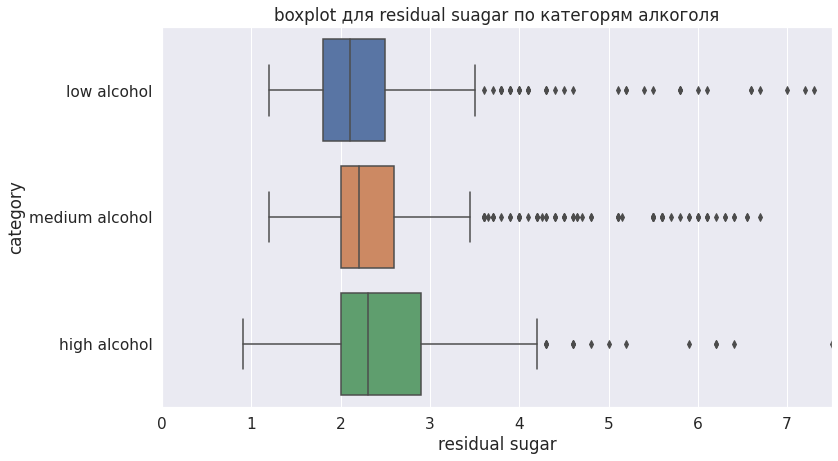

In [ ]:
palette = sns.color_palette("viridis", n_colors=3)[::-1]

plt.figure(figsize=(12,7))
sns.boxplot(y=data['category'], x=data['residual sugar'])
plt.xlim(0, 7.5)
plt.title('boxplot для residual suagar по категорям алкоголя')

Как соотнясятся оценки из предыдущего пункта и график сверху? Что лучше использовать для оценивания содержания сахара: медииану или среднее? Почему?

**Ответ:** оценки, полученные ранее соответствуют графику. Для оценивания лучше использовать медиану, так как из графика видно, что имеется довольно много выбросов, которые больше влияют на среднее, чем на медиану.  

Постройте один `scatterplot` (используйте `seaborn`) для очень хороших и очень плохих вин (`quality == 3`, `quality == 8`) в зависимости от содержания алкоголя (`alcohol` **не** из предыдущего пункта, а из колонки исходного датасета) и от количества лимонной кислоты (`citric acid`). Используйте `palette=[palette[0]]+[palette[-1]]`.

Text(0.5, 1.0, 'scatterplot для вин с разными оценками в зависимотси от содержания алкоголя и количества лимонной кислоты')

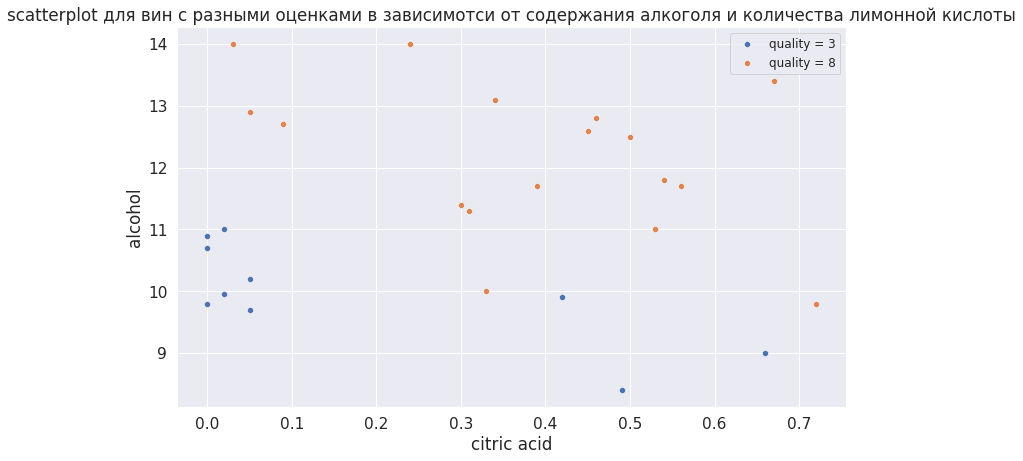

In [ ]:
temp_data = pd.concat([data[data['quality'] == 3], data[data['quality'] == 8]], ignore_index=True)
plt.figure(figsize=(12,7))
sns.scatterplot(data=data[data['quality'] == 3], x='citric acid', y='alcohol', palette=[palette[0]]+[palette[-1]], label='quality = 3')
sns.scatterplot(data=data[data['quality'] == 8], x='citric acid', y='alcohol', palette=[palette[0]]+[palette[-1]], label='quality = 8')
plt.legend(fontsize=12)
plt.title('scatterplot для вин с разными оценками в зависимотси от содержания алкоголя и количества лимонной кислоты')

Найдите ОМП для двух этих распределений в предположении, что обе выбоки из многомерного нормального распределения. Не мудрите, $\mu$ и $\Sigma$ получаются в одну команду через `numpy`. Далее получите плотности для сетки `X`, `Y`. Используйте `sps.multivariate_normal`.

In [ ]:
good_vine = (data[data.quality==8])[['citric acid', 'alcohol']]
bad_vine = (data[data.quality==3])[['citric acid', 'alcohol']]

mean_good = good_vine.mean()
mean_bad = bad_vine.mean()

print('Estimetion of the mean of citric acid:\n', 'quality = 3: ', mean_bad[0], '\n quality = 8: ', mean_good[0], '\n')
print('Estimetion of the mean of alcohol:\n', 'quality = 3: ', mean_bad[1], '\n quality = 8: ', mean_good[1], '\n')

var_good = np.dot((good_vine - mean_good).T, good_vine - mean_good)
var_bad = np.dot((bad_vine - mean_bad).T, bad_vine - mean_bad)

print('Estimetion of the variance matrix:\n', 'quality = 3:\n', var_bad, '\n quality = 8:\n', var_good)

Estimetion of the mean of citric acid:
 quality = 3:  0.17099999999999999 
 quality = 8:  0.3911111111111111 

Estimetion of the mean of alcohol:
 quality = 3:  9.955000000000002 
 quality = 8:  12.094444444444445 

Estimetion of the variance matrix:
 quality = 3:
 [[ 0.56549 -1.39505]
 [-1.39505  6.02225]] 
 quality = 8:
 [[ 0.67677778 -1.91088889]
 [-1.91088889 25.46944444]]


In [ ]:
x = np.linspace(-0.2, 0.8, 1000)
y = np.linspace(8, 15, 1000)
X, Y = np.meshgrid(x, y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
bad_densities = sps.multivariate_normal.pdf(pos, mean=mean_bad, cov=var_bad)
good_densities = sps.multivariate_normal.pdf(pos, mean=mean_good, cov=var_good)

Нарисуйте график плотности с линиями контура и нанесите точки выборки. Используйте зеленый цвет для вина плохого качества (`get_density_cmap("Greens")` и `"g"` для точек) и синий для вина хорошего качества (`get_density_cmap("Blues")` и `"b"`). Используйте функции `plt.pcolormesh`, `plt.clabel` и `plt.scatter`. Не забудьте про `plt.xlabel`, `plt.ylabel` и `plt.legend`.

In [ ]:
from matplotlib.colors import ListedColormap

def get_density_cmap(name):
    cmap =  plt.get_cmap(name)
    cmap_col = cmap(np.arange(cmap.N))
    cmap_col[:, -1] = np.linspace(0, 1, cmap.N)**2
    return ListedColormap(cmap_col)

Text(0.5, 1.0, 'Зависимость вин с разными оценками от содержания алкоголя и количества лимонной кислоты')

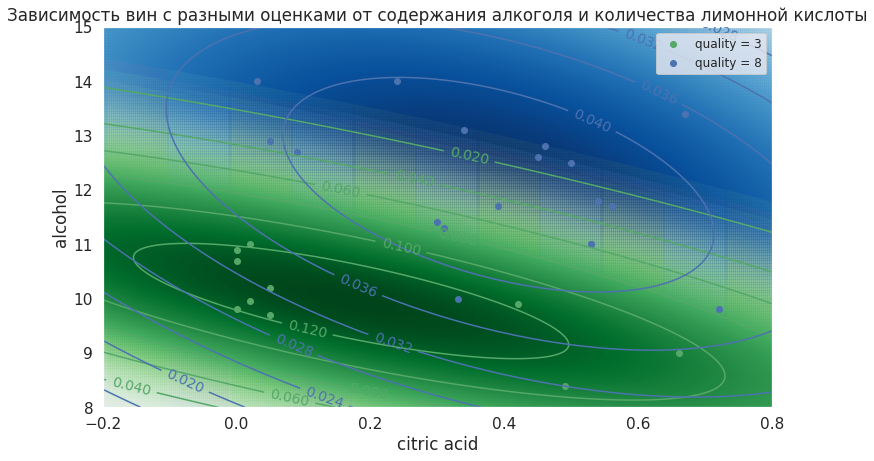

In [ ]:
plt.figure(figsize=(12,7))

plt.pcolormesh(X, Y, good_densities,  cmap=get_density_cmap("Blues"))
plt.pcolormesh(X, Y, bad_densities,  cmap=get_density_cmap("Greens"))

CS = plt.contour(X, Y, bad_densities, colors='g')
plt.clabel(CS, fontsize=14, inline=1, fmt='%1.3f', colors='g')

CS = plt.contour(X, Y, good_densities, colors='b')
plt.clabel(CS, fontsize=14, inline=1, fmt='%1.3f', colors='b')

plt.scatter(data=data[data['quality'] == 3], x='citric acid', y='alcohol', color='g', label='quality = 3')
plt.scatter(data=data[data['quality'] == 8], x='citric acid', y='alcohol', color='b', label='quality = 8')


plt.xlabel('citric acid')
plt.ylabel('alcohol')
plt.legend(fontsize=12)
plt.title('Зависимость вин с разными оценками от содержания алкоголя и количества лимонной кислоты')

Что можно сказать о вине, которому сомелье дали наивысший балл по сравнению с вином, которому дали наименьший балл, основываясь на график выше?

**Ответ:** вино с оценкой 8, как правило, содержит больше алкоголя и больше лимонной кислоты, чем вино с оценкой 3.  

# Задача 3

Рассмотрим $X_1, ..., X_n \sim Bern(\theta)$. По сетке значений $ \theta \in [0, 1]$ с шагом 0.01 постройте график зависимости нижней оценки дисперсии произвольной несмещенной оценки из неравенства Рао-Крамера от $\theta$. 

Неравенство Рао-Фишера:
$$
{D} \theta \geq \frac{1}{nI(\theta)}, 
$$
где $I(\theta)$ -- информация Фишера:\
$$I(\theta) = \frac{1}{\theta(1-\theta)}$$ \
Полгая $n = 1000$, рассчитаем инфрмацию Фишера.

In [ ]:
I = np.array([1 / (theta * (1 - theta)) for theta in np.arange(0.01, 1, 0.01)])

Text(0, 0.5, 'Нижняя оценка')

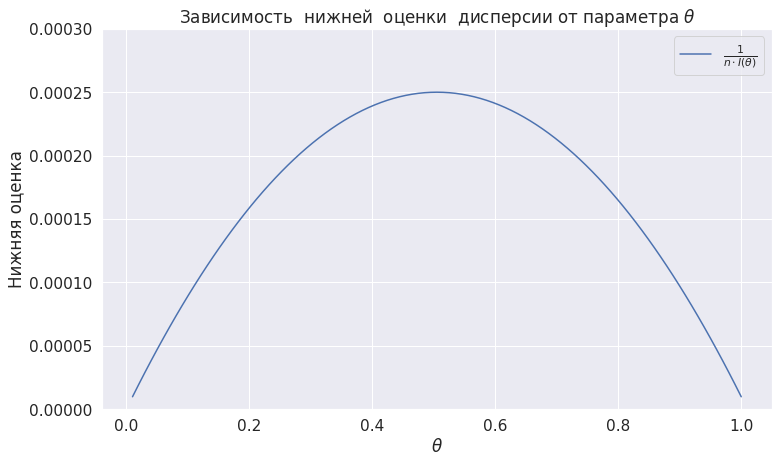

In [ ]:
N = 1000
plt.figure(figsize=(12, 7))
plt.plot(np.linspace(0.01, 1, 99), 1 /(N * I), label=r'$\frac{1}{n \cdot I(\theta)}$')
plt.ylim(0, 0.0003)

plt.legend()
plt.title(r'Зависимость  нижней  оценки  дисперсии от параметра $\theta$')
plt.xlabel(r'$\theta$')
plt.ylabel('Нижняя оценка')

Какой можно сделать вывод (напишите в комментариях)?

**Вывод** нижняя оценка достигает максимумуа при $\theta=0.5$. То есть при данном значении параметра в одном наблюдении содержится минимальное количество информации Фишера.

 Для каждого значения $\theta$ (для той же сетки) сгенерируйте выборку размера $n=1000$ для параметра $\theta$, посчитайте эффективную оценку $\theta$ и бутстрепную оценку дисперсии (количество бутстрепных выборок равно $1000$) этой эффективной оценки $\theta$.

In [ ]:
K = 500
variance = []
grad=np.linspace(0.01, 1, 100)
for theta in grad:
    sample = sps.binom.rvs(1, theta, size=N)
    eff_estimate = np.cumsum(sample) / np.arange(1, N + 1)
    samples = np.array([sps.binom.rvs(1, eff_estimate[N - 1], size=N) for k in range(K)])
    effs = np.array([np.cumsum(samples[k]) / np.arange(1, N + 1) for k in range(K)])
    var = np.sum(np.array([effs[k][N - 1] for k in range(K)]) ** 2) / K - (np.sum([effs[k][N - 1] for k in range(K)]) / K) ** 2
    variance.append(var)
    

 Нарисуйте график зависимости полученных бутстрепных оценок от $\theta$.

Text(0, 0.5, 'Значение дисперсии')

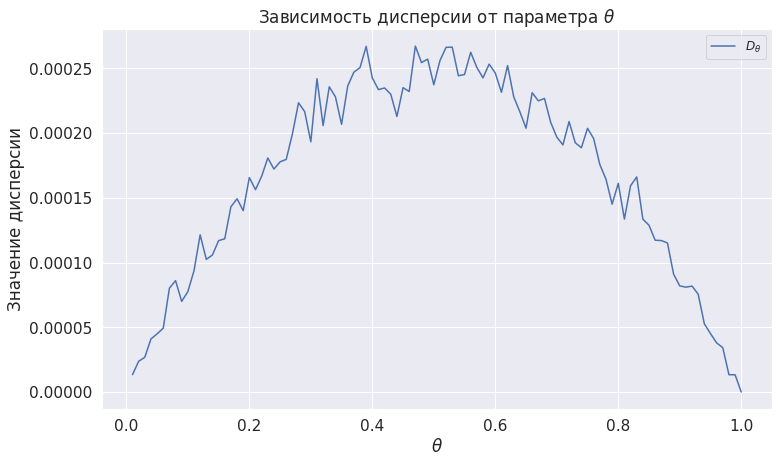

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(grad, variance, label=r'$D_{\theta}$')
plt.title(r'Зависимость дисперсии от параметра $\theta$')
plt.legend(fontsize=12)
plt.xlabel(r'$\theta$')
plt.ylabel('Значение дисперсии')

**Вывод:** из графика видно, что оценка $\overline{X}$ действительно является эффективной для распределения Бернулли.